### DQN解决倒立摆问题

表格型方法存储的状态数量有限，当面对围棋或机器人控制这类有数不清的状态的环境时，表格型方法在存储和查找效率上都受局限，DQN的提出解决了这一局限，**使用神经网络来近似替代Q表格**。

本质上DQN还是一个Q-learning算法，更新方式一致。为了更好的探索环境，同样的也采用epsilon-greedy方法训练。

在Q-learning的基础上，DQN提出了两个技巧使得Q网络的更新迭代更稳定。

* 经验回放(Experience Replay): 使用一个经验池存储多条经验s,a,r,s'，再从中随机抽取一批数据送去训练。

* 固定目标(Fixed Q-Target): 复制一个和原来Q网络结构一样的Target-Q网络，用于计算Q目标值。


### 一，准备环境

gym是一个常用的强化学习测试环境，可以用make创建环境。

env具有reset,step,render几个方法。


**倒立摆问题** 

环境设计如下：

倒立摆问题环境的状态是无限的，用一个4维的向量表示state.

4个维度分别代表如下含义

* cart位置：-2.4 ~ 2.4
* cart速度：-inf ~ inf
* pole角度：-0.5 ～ 0.5 （radian）
* pole角速度：-inf ~ inf

智能体设计如下：

智能体的action有两种，可能的取值2种：

* 0，向左
* 1，向右

奖励设计如下：

每维持一个步骤，奖励+1，到达200个步骤，游戏结束。

所以最高得分为200分。

倒立摆问题希望训练一个智能体能够尽可能地维持倒立摆的平衡。


In [6]:
import gym 
import numpy as np 
import pandas as pd 
import time
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

print("gym.__version__=",gym.__version__)


%matplotlib inline

#可视化函数：
def show_state(env, step, info=''):
    plt.figure(num=10086,dpi=100)
    plt.clf()
    plt.imshow(env.render())
    plt.title("step: %d %s" % (step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()
    

env = gym.make('CartPole-v1',render_mode="rgb_array") # CartPole-v0: 预期最后一次评估总分 > 180（最大值是200）
env.reset()
action_dim = env.action_space.n   # CartPole-v0: 2
obs_shape = env.observation_space.shape   # CartPole-v0: (4,)



gym.__version__= 0.26.2


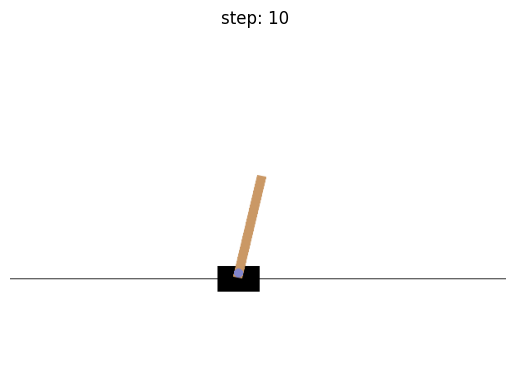

In [9]:
env.reset()
done = False
step = 0
while not done:
    
    action = np.random.randint(0, 1)
    state,reward,done,truncated,info = env.step(action)
    step+=1
    print(state,reward)
    time.sleep(1.0)
    #env.render() 
    show_state(env,step=step)
    #print('step {}: action {}, state {}, reward {}, done {}, truncated {}, info {}'.format(\
    #        step, action, state, reward, done, truncated,info))
    
display.clear_output(wait=True)

### 二，定义Agent 

DQN的核心思想为使用一个神经网络来近似替代Q表格。

Model: 模型结构, 负责拟合函数 Q(s,a)。主要实现forward方法。

Agent:智能体，负责学习并和环境交互, 输入输出是numpy.array形式。有sample(单步采样), predict(单步预测), 有predict_batch(批量预测), compute_loss(计算损失), sync_target(参数同步)等方法。



In [10]:
import torch 
from torch import nn
import torch.nn.functional as F
import copy 

class Model(nn.Module):
    def __init__(self, obs_dim, action_dim):
        
        # 3层全连接网络
        super(Model, self).__init__()
        self.obs_dim = obs_dim
        self.action_dim = action_dim 
        self.fc1 = nn.Linear(obs_dim,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,action_dim)

    def forward(self, obs):
        # 输入state，输出所有action对应的Q，[Q(s,a1), Q(s,a2), Q(s,a3)...]
        x = self.fc1(obs)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        Q = self.fc3(x)
        return Q
    
model = Model(4,2)
model_target = copy.deepcopy(model)

model.eval()
model.forward(torch.tensor([[0.2,0.1,0.2,0.0],[0.3,0.5,0.2,0.6]]))

model_target.eval() 
model_target.forward(torch.tensor([[0.2,0.1,0.2,0.0],[0.3,0.5,0.2,0.6]]))



tensor([[-0.1148,  0.0068],
        [-0.1311,  0.0315]], grad_fn=<AddmmBackward0>)

In [11]:
import torch 
from torch import nn 
import copy 

class DQNAgent(nn.Module):
    def __init__(self, model, 
        gamma=0.9,
        e_greed=0.1,
        e_greed_decrement=0.001
        ):
        super().__init__()
        
        self.model = model
        self.target_model = copy.deepcopy(model)
  
        self.gamma = gamma # reward 的衰减因子，一般取 0.9 到 0.999 不等
        
        self.e_greed = e_greed  # 有一定概率随机选取动作，探索
        self.e_greed_decrement = e_greed_decrement  # 随着训练逐步收敛，探索的程度慢慢降低
        
        self.global_step = 0
        self.update_target_steps = 200 # 每隔200个training steps再把model的参数复制到target_model中
        
        
    def forward(self,obs):
        return self.model(obs)
    
    @torch.no_grad()
    def predict_batch(self, obs):
        """ 使用self.model网络来获取 [Q(s,a1),Q(s,a2),...]
        """
        self.model.eval()
        return self.forward(obs)
    
    
    #单步骤采样    
    def sample(self, obs):
        sample = np.random.rand()  # 产生0~1之间的小数
        if sample < self.e_greed:
            action = np.random.randint(self.model.action_dim)  # 探索：每个动作都有概率被选择
        else:
            action = self.predict(obs)  # 选择最优动作
        self.e_greed = max(
            0.01, self.e_greed - self.e_greed_decrement)  # 随着训练逐步收敛，探索的程度慢慢降低
        return action
    
    #单步骤预测   
    def predict(self, obs):  # 选择最优动作
        obs = np.expand_dims(obs, axis=0)
        tensor = torch.tensor(obs,dtype=torch.float32).to(self.model.fc1.weight.device)
        pred_Q = self.predict_batch(tensor)
        action = torch.argmax(pred_Q,1,keepdim=True).cpu().numpy()  
        action = np.squeeze(action)
        return action
    
    
    def sync_target(self):
        """ 把 self.model 的模型参数值同步到 self.target_model
        """
        self.target_model.load_state_dict(self.model.state_dict())
    

    def compute_loss(self, obs, action, reward, next_obs, done):
        
        # 每隔200个training steps同步一次model和target_model的参数
        if self.global_step % self.update_target_steps == 0:
            self.sync_target()
        self.global_step += 1
        
        
        # 从target_model中获取 max Q' 的值，用于计算target_Q
        self.target_model.eval()
        next_pred_value = self.target_model(next_obs)
        best_value = torch.max(next_pred_value, dim = 1,keepdim=True).values 
        target = reward.reshape((-1,1)) + (
            torch.tensor(1.0) - done.reshape(-1,1)) * self.gamma * best_value
        
        #print("best_value",best_value.shape)
        #print("target",target.shape)

        # 获取Q预测值
        self.model.train()
        pred_value = self.model(obs)  
        action_onehot = F.one_hot(action.reshape(-1),
                num_classes = self.model.action_dim).float()
        prediction = torch.sum(pred_value*action_onehot,dim= 1,keepdim=True)
        
        #print("pred_value",pred_value.shape)
        #print("action_onehot",action_onehot.shape)
        #print("prediction",prediction.shape)
        
        # 计算 Q(s,a) 与 target_Q的均方差，得到loss
        loss = F.smooth_l1_loss(target,prediction)
        return loss 


In [12]:
agent = DQNAgent(model,gamma=0.9,e_greed=0.1,
                 e_greed_decrement=0.001) 


In [13]:
agent.predict_batch(torch.tensor([[2.0,3.0,4.0,2.0],[1.0,2.0,3.0,4.0]]))


tensor([[-0.1596, -0.0481],
        [-0.0927,  0.0318]])

In [14]:
loss = agent.compute_loss(torch.tensor([[2.0,3.0,4.0,2.0],[1.0,2.0,3.0,4.0],[1.0,2.0,3.0,4.0]]),
          torch.tensor([[1],[0],[0]]),
          torch.tensor([[1.0],[1.0],[1.0]]),
         torch.tensor([[2.0,3.0,0.4,2.0],[1.0,2.0,3.0,4.0],[1.0,2.0,3.0,4.0]]),
         torch.tensor(0.9))
print(loss)

tensor(0.5757, grad_fn=<SmoothL1LossBackward0>)


### 三，训练Agent 

In [15]:
import random
import collections
import numpy as np

LEARN_FREQ = 5 # 训练频率，不需要每一个step都learn，攒一些新增经验后再learn，提高效率
MEMORY_SIZE = 2048    # replay memory的大小，越大越占用内存
MEMORY_WARMUP_SIZE = 512  # replay_memory 里需要预存一些经验数据，再开启训练
BATCH_SIZE = 128   # 每次给agent learn的数据数量，从replay memory随机里sample一批数据出来


In [16]:
#经验回放
class ReplayMemory(object):
    def __init__(self, max_size):
        self.buffer = collections.deque(maxlen=max_size)

    # 增加一条经验到经验池中
    def append(self, exp):
        self.buffer.append(exp)

    # 从经验池中选取N条经验出来
    def sample(self, batch_size):
        mini_batch = random.sample(self.buffer, batch_size)
        obs_batch, action_batch, reward_batch, next_obs_batch, done_batch = [], [], [], [], []

        for experience in mini_batch:
            s, a, r, s_p, done = experience
            obs_batch.append(s)
            action_batch.append(a)
            reward_batch.append(r)
            next_obs_batch.append(s_p)
            done_batch.append(done)

        return np.array(obs_batch).astype('float32'), \
            np.array(action_batch).astype('int64'), np.array(reward_batch).astype('float32'),\
            np.array(next_obs_batch).astype('float32'), np.array(done_batch).astype('float32')

    def __len__(self):
        return len(self.buffer)
    

In [17]:
from torch.utils.data import IterableDataset,DataLoader  
class MyDataset(IterableDataset):
    def __init__(self,env,agent,rpm,stage='train',size=200):
        self.env = env
        self.agent = agent 
        self.rpm = rpm if stage=='train' else None
        self.stage = stage
        self.size = size 
        
    def __iter__(self):
        obs,info = self.env.reset() # 重置环境, 重新开一局（即开始新的一个episode）
        step = 0
        batch_reward_true = [] #记录真实的reward
        while True:
            step += 1
            action = self.agent.sample(obs) 
            next_obs, reward, done, _, _ = self.env.step(action) # 与环境进行一个交互
            batch_reward_true.append(reward)
            
            if self.stage=='train':
                self.rpm.append((obs, action, reward, next_obs, float(done)))
                if (len(rpm) > MEMORY_WARMUP_SIZE) and (step % LEARN_FREQ == 0):
                    #yield batch_obs, batch_action, batch_reward, batch_next_obs,batch_done
                    yield self.rpm.sample(BATCH_SIZE),sum(batch_reward_true)
                    batch_reward_true.clear()
            
            else:
                obs_batch = np.array([obs]).astype('float32')
                action_batch = np.array([action]).astype('int64')
                reward_batch = np.array([reward]).astype('float32')
                next_obs_batch = np.array([next_obs]).astype('float32')
                done_batch = np.array([float(done)]).astype('float32')
                batch_data = obs_batch,action_batch,reward_batch,next_obs_batch,done_batch
                yield batch_data,sum(batch_reward_true)
                batch_reward_true.clear()
            
    
            if self.stage =='train':
                next_action = self.agent.sample(next_obs) # 训练阶段使用探索策略
            else:
                next_action = self.agent.predict(next_obs) # 验证阶段使用模型预测结果
 
            action = next_action
            obs = next_obs   

            if done:
                if self.stage=='train' and len(self.rpm)<MEMORY_WARMUP_SIZE: #确保训练一次
                    yield self.rpm.sample(len(self.rpm)),sum(batch_reward_true)
                    batch_reward_true.clear()
                    break
                else:
                    break
    def __len__(self):
        return self.size 
    

env = gym.make('CartPole-v1') 
rpm = ReplayMemory(MEMORY_SIZE)

ds_train = MyDataset(env,agent,rpm,stage='train',size=1000)
ds_val = MyDataset(env,agent,rpm,stage='val',size=200)


In [18]:
#ReplayMemory预存数据
while len(ds_train.rpm)<MEMORY_WARMUP_SIZE:
    for data in ds_train:
        print(len(ds_train.rpm))
        

13
23
36
47
59
71
81
94
108
119
131
144
154
167
180
191
203
215
225
238
248
257
272
286
299
311
322
332
342
354
364
376
388
401
415
428
438
450
462
475
489
499
511
516
521


In [19]:
def collate_fn(batch):
    samples,rewards = [x[0] for x in batch],[x[-1] for x in batch] 
    samples = [torch.from_numpy(np.concatenate([x[j] for x in samples])) for j in range(5)] 
    rewards = torch.from_numpy(np.array([sum(rewards)]).astype('float32'))
    return samples,rewards 

dl_train = DataLoader(ds_train,batch_size=1,collate_fn=collate_fn)
dl_val = DataLoader(ds_val,batch_size=1,collate_fn=collate_fn)


In [20]:
for batch in dl_train:
    break

In [21]:
import sys,datetime
from tqdm import tqdm
import numpy as np
from accelerate import Accelerator
from torchkeras import KerasModel
import pandas as pd 

from copy import deepcopy

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator()
    
    def __call__(self, batch):
        
        samples,reward = batch
        #torch_data = ([torch.from_numpy(x) for x in batch_data])
        loss = self.net.compute_loss(*samples)
        
        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
                
            
        #losses （or plain metric）
        step_losses = {self.stage+'_reward':reward.item(), 
                       self.stage+'_loss':loss.item()}
        
        #metrics (stateful metric)
        step_metrics = {}
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    

class EpochRunner:
    def __init__(self,steprunner,quiet=False):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        self.accelerator = steprunner.accelerator
        self.net = steprunner.net
        self.quiet = quiet
        
    def __call__(self,dataloader):
        dataloader.agent = self.net 
        n = dataloader.size  if hasattr(dataloader,'size') else len(dataloader)
        loop = tqdm(enumerate(dataloader,start=1), 
                    total=n,
                    file=sys.stdout,
                    disable=not self.accelerator.is_local_main_process or self.quiet,
                    ncols=100
                   )
        epoch_losses = {}
        for step, batch in loop: 
            if step<n:
                step_losses,step_metrics = self.steprunner(batch)   
                step_log = dict(step_losses,**step_metrics)
                for k,v in step_losses.items():
                    epoch_losses[k] = epoch_losses.get(k,0.0)+v
                loop.set_postfix(**step_log) 
            else:
                break
            
        epoch_metrics = step_metrics
        epoch_metrics.update({self.stage+"_"+name:metric_fn.compute().item() 
                         for name,metric_fn in self.steprunner.metrics_dict.items()})
        epoch_losses = {k:v for k,v in epoch_losses.items()}
        epoch_log = dict(epoch_losses,**epoch_metrics)
        loop.set_postfix(**epoch_log)

        for name,metric_fn in self.steprunner.metrics_dict.items():
            metric_fn.reset()
            
        return epoch_log
    
KerasModel.StepRunner = StepRunner
KerasModel.EpochRunner = EpochRunner 


<<<<<< 🐌 cpu is used >>>>>>


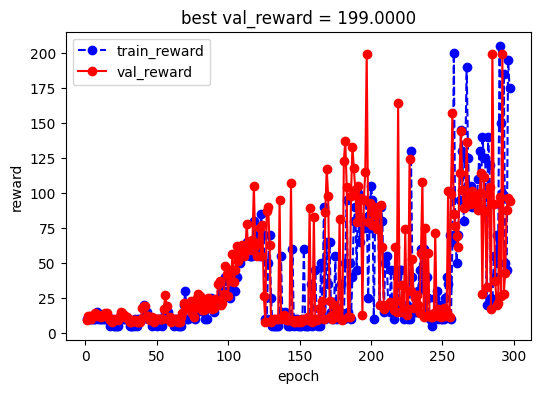

<<<<<< val_reward without improvement in 100 epoch,early stopping >>>>>>


In [22]:
keras_model = KerasModel(net= agent,loss_fn=None,
        optimizer=torch.optim.Adam(agent.model.parameters(),lr=1e-2))

dfhistory = keras_model.fit(train_data = dl_train,
    val_data=dl_val,
    epochs=600,
    ckpt_path='checkpoint.pt',
    patience=100,
    monitor='val_reward',
    mode='max',
    callbacks=None,
    plot= True,
    cpu=True)


### 四，评估Agent 

In [26]:
# 评估 agent, 跑 3 次，总reward求平均
def evaluate(env, agent, render=False):
    eval_reward = []
    for i in range(2):
        obs,info = env.reset()
        episode_reward = 0
        step=0
        while step<300:
            action = agent.predict(obs)  # 预测动作，只选最优动作
            obs, reward, done, _, _ = env.step(action)
            episode_reward += reward
            if render:
                show_state(env,step,info='reward='+str(episode_reward))
            if done:
                break
            step+=1
        eval_reward.append(episode_reward)
    return np.mean(eval_reward)


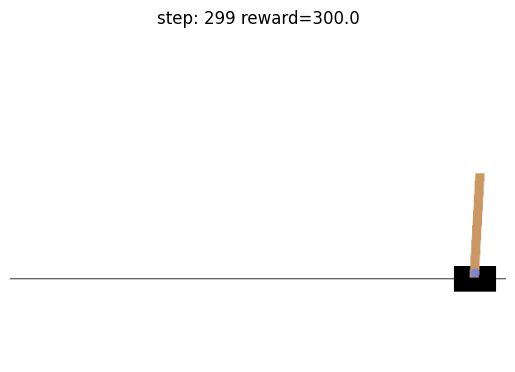

288.5

In [27]:
#直观显示动画
env = gym.make('CartPole-v1',render_mode="rgb_array") 

evaluate(env, agent, render=True)


### 五，保存Agent 

In [59]:
torch.save(agent.state_dict(),'dqn_agent.pt')